In [1]:
import os

# Prepend TeX Live 2025 bin directory to PATH
os.environ['PATH'] = '/scratch/ope4/texlive/2025/bin/x86_64-linux:' + os.environ['PATH']

# Optional: check that the correct latex is found
!which latex
!latex --version


/scratch/ope4/texlive/2025/bin/x86_64-linux/latex
pdfTeX 3.141592653-2.6-1.40.28 (TeX Live 2025)
kpathsea version 6.4.1
Copyright 2025 Han The Thanh (pdfTeX) et al.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Han The Thanh (pdfTeX) et al.
Compiled with libpng 1.6.46; using libpng 1.6.46
Compiled with zlib 1.3.1; using zlib 1.3.1
Compiled with xpdf version 4.04


## Estimating space- and time-varying transmission rate from data
# Exercise 1
# https://docs.www.epimorph.org/demo/G1.L2.1-pf.html


In [2]:
#CustomScopes give you the most flexibility in representing geography.

#nodes = number of locations
#node IDS = A,B,C: the name of our grid_cell/polygons
#node labels is the same as the ID
from epymorph.kit import *
import numpy as np

from epymorph.kit import *
from epymorph.adrio import acs5
from epymorph.initializer import Proportional



In [3]:
scope = CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"])
scope

In [4]:
import numpy as np

centroids = np.array(
    [
        #(-111.5, 33.8),
        #(-106.6, 35.2),
        #(-109.3, 32.1),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
    ],
    dtype=CentroidDType  # already imported with epymorph.kit
)



In [5]:
"""Defines a compartmental IPM for a generic SIRH model."""

from sympy import Max

from epymorph.attribute import AttributeDef
from epymorph.compartment_model import CompartmentModel, compartment, edge, fork
from epymorph.data_shape import Shapes


class SIRS_TREES(CompartmentModel):
    """A basic SIRH model."""

    compartments = [
        compartment("S", tags=["immobile"]),
        compartment("I", tags=["immobile"]),
        compartment("D", tags=["immobile"]),
        compartment("H", tags=["immobile"]),
        compartment("X", tags=["mobile"]),
    ]

    requirements = [
        AttributeDef("beta", type=float, shape=Shapes.TxN, comment="infectivity"),
        AttributeDef("gamma", type=float, shape=Shapes.TxN, comment="recovery rate"),
        AttributeDef("xi", type=float, shape=Shapes.TxN, comment="immune waning rate"),
        AttributeDef(
            "hospitalization_prob",
            type=float,
            shape=Shapes.TxN,
            comment="a ratio of cases which are expected to require hospitalization",
        ),
        AttributeDef(
            "hospitalization_duration",
            type=float,
            shape=Shapes.TxN,
            comment="the mean duration of hospitalization, in days",
        ),
        AttributeDef(
            "birth_rate",
            type=float,
            shape=Shapes.TxN,
            comment="birth rate per day per capita",
        ),
        AttributeDef(
            "leave_rate", ##the rate each new produce bettle leaves it host tree and move to a new tree
            type=float,
            shape=Shapes.TxN,
            comment="birth rate per day per capita",
        ),
        AttributeDef(
            "et_factor", ##the rate each new produce bettle leaves it host tree and move to a new tree
            type=float,
            shape=Shapes.TxN,
            comment="birth rate per day per capita",
        ),
    ]

    def edges(self, symbols):
        [S, I, D, H, X] = symbols.all_compartments
        [β, γ, ξ, h_prob, h_dur, br, lr, et_factor] = symbols.all_requirements
        

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S + I + D + H + X + br + lr)

        return [
            edge(S, I, rate=β * S * X / N), ## S->I1 influenced by X
            fork(
                edge(I, H, rate=γ * I * h_prob),
                #edge(I, D, rate=γ * I * (1 - h_prob)),
            ),
            edge(H, D, rate=H / h_dur),  
            edge(X, X, rate=0),
            edge(X, BIRTH, rate = lr * br * et_factor * X) # Beetle dispersal + reproduction (climate-modulated)
  
        ]


/home/ope4/.local/lib/python3.11/site-packages/epymorph/compartment_model.py:717: UserWarning: Possible issue in SIRS_TREES: not all declared requirements are being used in transitions.
Extra requirements: xi
  warn(msg)


In [6]:
from functools import cached_property

import numpy as np
from numpy.typing import NDArray

from epymorph.attribute import AttributeDef
from epymorph.data_shape import Shapes
from epymorph.data_type import CentroidType, SimDType
from epymorph.movement_model import EveryDay, MovementClause, MovementModel
from epymorph.simulation import Tick, TickDelta, TickIndex
from epymorph.util import pairwise_haversine, row_normalize


class CentroidsClause(MovementClause):
    """The clause of the centroids model."""

    requirements = (
        AttributeDef(
            "population", int, Shapes.N, comment="The total population at each node."
        ),
        AttributeDef(
            "centroid",
            CentroidType,
            Shapes.N,
            comment="The centroids for each node as (longitude, latitude) tuples.",
        ),
        AttributeDef(
            "phi",
            float,
            Shapes.Scalar,
            default_value=40.0, #can this be NA since we dont know how far they can travel?
            comment="Influences the distance that movers tend to travel.",
        ),
        AttributeDef(
            "commuter_proportion",
            float,
            Shapes.Scalar,
            default_value=0.1,
            comment="The proportion of the total population which commutes.",
        ),
    )

    predicate = EveryDay()
    leaves = TickIndex(step=0)
    returns = TickDelta(step=1, days=0)

    @cached_property
    def dispersal_kernel(self) -> NDArray[np.float64]:
        """
        The NxN matrix or dispersal kernel describing the tendency for movers to move
        to a particular location. In this model, the kernel is:
            1 / e ^ (distance / phi)
        which is then row-normalized.
        """
        centroid = self.data("centroid")
        phi = self.data("phi")
        distance = pairwise_haversine(centroid)
        return row_normalize(1 / np.exp(distance / phi))

    def evaluate(self, tick: Tick) -> NDArray[np.int64]:
        pop = self.data("population")
        comm_prop = self.data("commuter_proportion")
        n_commuters = np.floor(pop * comm_prop).astype(SimDType)
        return self.rng.multinomial(n_commuters, self.dispersal_kernel)

class BeetleAwayClause(MovementClause):
    """Clause for beetles that leave home and stay away all day."""

    requirements = CentroidsClause.requirements  # same requirements
    #NEVER = TickDelta(step=0, days=0)  # negative day signals "never" in epymorph

    predicate = EveryDay()
    leaves = TickIndex(step=0)   # they leave at start
    returns = TickDelta(step=0, days=0)  # no return within the day!
    #returns = NEVER #They never return
    


    @cached_property
    def dispersal_kernel(self) -> NDArray[np.float64]:
        centroid = self.data("centroid")
        phi = self.data("phi")
        distance = pairwise_haversine(centroid)
        return row_normalize(1 / np.exp(distance / phi))

    def evaluate(self, tick: Tick) -> NDArray[np.int64]:
        pop = self.data("population")
        comm_prop = self.data("commuter_proportion")
        n_commuters = np.floor(pop * comm_prop).astype(SimDType)
        return self.rng.multinomial(n_commuters, self.dispersal_kernel)

class Centroids(MovementModel):
    """
    The centroids MM describes a basic commuter movement where a fixed proportion
    of the population commutes every day, travels to another location for 1/3 of a day
    (with a location likelihood that decreases with distance), and then returns home for
    the remaining 2/3 of the day.
    """

    steps = (1 / 3, 2/ 3) 
    clauses = (CentroidsClause(),)

class BeetleAwayAllDay(MovementModel):
    """Beetles leave home and stay away all day."""
    steps = (1.0,)   # only one step
    clauses = (BeetleAwayClause(),) # probalility that the BB travels 3/3 times of the day and also returns 3/3 times of the day.




In [7]:
## import climate variable from ADIRO

from datetime import date
from epymorph.kit import *
from epymorph.kit import *
from epymorph.adrio import us_tiger, prism, humidity

precip_adrio = prism.Precipitation()
mean_temp_adrio = prism.Temperature("Mean")

with sim_messaging(live=False):
    relH = (
        humidity.RelativeHumidity()
        .with_context(
            scope=scope,
            time_frame=TimeFrame.rangex("2021-01-01", "2021-01-30"), ## the simulation will run for a 3 years,
            params={
                "centroid": centroids,
                "temperature": prism.Temperature("Mean"),
                "dewpoint": prism.DewPoint(),
            },
        )
        .evaluate()
    )

Loading (unspecified)::(unspecified)::temperature (epymorph.adrio.prism.Temperature):
  |####################| 100%  (1.026s)
Loading (unspecified)::(unspecified)::dewpoint (epymorph.adrio.prism.DewPoint):
  |####################| 100%  (0.626s)
Loading epymorph.adrio.humidity.RelativeHumidity:
  |####################| 100%  (0.001s)


In [8]:
# Convert RH % to 0–1
relH_norm = relH.mean(axis=0) / 100.0

# Invert to get beetle success factor
et_factor = 1 - relH_norm

# Clip to avoid zero or negative rates
et_factor = np.clip(et_factor, 0.05, 1.0)  # min 0.05


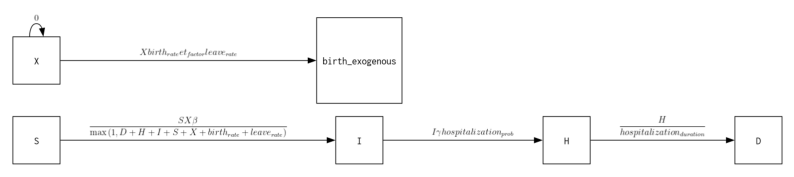

In [9]:
##model conceptual diagram

SIRS_TREES().diagram()

In [10]:
import numpy as np

from epymorph.kit import *
from epymorph.adrio import acs5
from epymorph.initializer import Proportional

In [11]:

#Construct a RUME with a scope consisting of our scope, 
# but assume that there is no movement between the states. Essentially, 
# this simulates four independent populations. Use an SIRH IPM. In each State, 
# initialize a small fraction initially infectious. Run for 26 weeks.

n = 8 #number of scope
rume = SingleStrataRUME.build(
    #ipm=ipm.SIRH(),
    ipm=SIRS_TREES(),
    #mm=mm.No(),
    mm=BeetleAwayAllDay(),
    scope=StateScope.in_states(["AZ", "CO", "NM", "UT", "GA", "FL", "CA", "NY"], year = 2021),
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([9999, 1, 0, 0, 100], dtype=np.int64), shape=(n, 5) #number of individual in each compartment, so S= 9999 etc.
        )
    ),
    #init=init,
    time_frame=TimeFrame.of("2021-07-25", 7 * 104 + 1),
    params={
        "beta": 0.3,  # Placeholder value
        "gamma": 0.2,
        "xi": 1 / 365,
        "birth_rate": 1 / 365,  # one adult offspring per year, how much do they reproduce in a year?
        "leave_rate": 1 / 365,  # leaves host tree roughly once per year
        # example: invert humidity to get beetle success (0–1)
        "et_factor": et_factor[:n],  # average over time for each grid/state
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0, ##ask tyler if this duration can be made into number of days the insect stays in a particular tree etc
        "population": [
            #4_151_502, # Arizona
            #4_773_714, # Colorado
            #4_117_522#, # New Mexico
            #4_271_616, # Utah
            1_326, #total tree population per 100m by 100m grid
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326
        ],
        "centroid": centroids,
    },
)

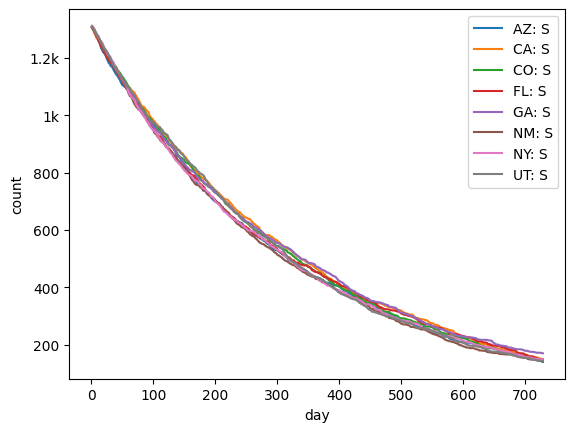

In [12]:
sim = BasicSimulator(rume)
output = sim.run(rng_factory=default_rng(42))

output.plot.line(
    geo=output.rume.scope.select.all(),
    time=output.rume.time_frame.select.all(),
    quantity=output.rume.ipm.select.compartments("S"),
)

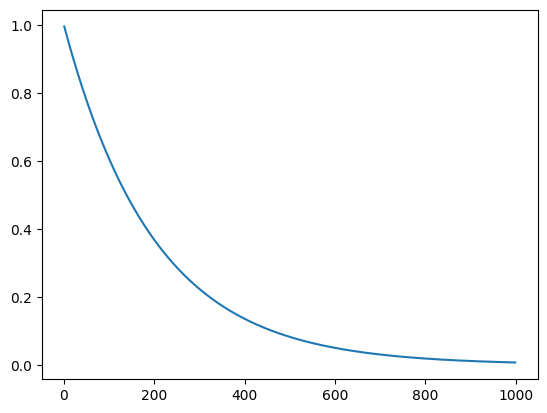

In [13]:
##prob of occuring aganist distance:

import matplotlib.pyplot as plt
phi = 200.0 ##can be any value but good to find a constant
xs = np.arange(1,1000) #this should be the actual distance between the grid cells A
ys = 1 / np.exp(xs / phi)

plt.plot(xs, ys)
plt.show()

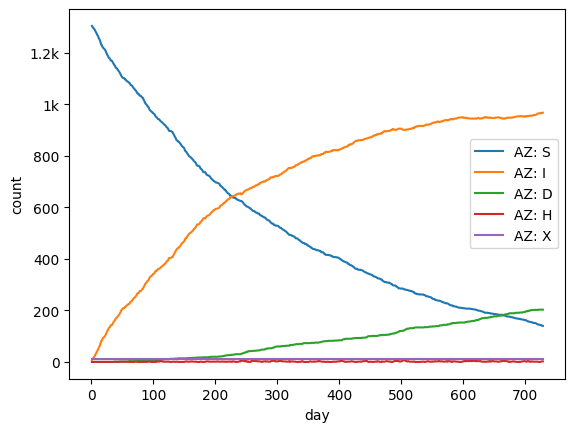

In [35]:
## plot of how all the grid cells compartments will behave
#state_fips = {"AZ":"04","CO":"08","NM":"35","UT":"49",
 #             "GA":"13","FL":"12","CA":"06","NY":"36"}


output.plot.line(
    geo=output.rume.scope.select.by_id("04"),
    time=output.rume.time_frame.select.all(),
    quantity=output.rume.ipm.select.compartments(),
    #quantity=selected_compartments,
)

In [ ]:
from epymorph.adrio import acs5, csv
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
import numpy as np

from epymorph.kit import *

num_weeks = 156
duration = 7 * num_weeks + 1
t = np.arange(0, duration)
true_beta = 0.05 * np.cos(t * 2 * np.pi / (365)) + 0.25

import matplotlib.pyplot as plt

plt.plot(t, true_beta)
plt.ylabel("beta")
plt.xlabel("time (days)")
plt.title("The transmission rate (beta) over time")
plt.show()

In [ ]:
#Run the model.
rng = np.random.default_rng(seed=1)

sim = BasicSimulator(rume)
with sim_messaging(live = False):
    out = sim.run(rng_factory=(lambda: rng))

In [ ]:
#Use epymorph’s aggregation functionality to aggregate the weekly hospitalizations, 
# then save the synthetic data to a .csv file. 
# In this case we are specifying that the data observations are new hospitalizations, aggregated per seven days.
import tempfile

from epymorph.time import EveryNDays
from epymorph.tools.data import munge

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

cases_df = munge(
    out,
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)
cases_df.tail(10) #last ten rows


In [ ]:
# We'll use a temporary file here,
#    but typically you would use a normal file.
temp_file = tempfile.NamedTemporaryFile(suffix=".csv", delete=False).name
cases_df.to_csv(temp_file, index=False)

In [ ]:
import pandas as pd
from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.time import EveryNDays
import tempfile
from datetime import datetime, timedelta


# -------------------------------
# Step 0: Define states and FIPS
# -------------------------------
nodes = ["AZ","CO","NM","UT","GA","FL","CA","NY"]
state_fips = {"AZ":"04","CO":"08","NM":"35","UT":"49",
              "GA":"13","FL":"12","CA":"06","NY":"36"}
population = [1326] * 8
death_percentages = [18.789615, 8.708416, 19.639209, 14.259614, 
                     19.297432, 13.18899, 22.60519, 6.599833]

# -------------------------------
# Step 1: Build RUME
# -------------------------------
# Define TimeFrame: start date + number of days
n_days = 7*104 + 1  # 2 years in weeks +1
start_date = datetime(2021,7,25)
time_frame = TimeFrame.of("2021-07-25", n_days)

# Scope using FIPS
scope = StateScope.in_states(nodes, year=2021)


# -------------------------------
# Step 2: Create observed data
# -------------------------------
# Baseline: day 0
baseline_date = start_date
baseline = pd.DataFrame({
    "time": [baseline_date.strftime("%Y-%m-%d")] * len(nodes),
    "geo": [state_fips[s] for s in nodes],
    "value": [0]*len(nodes)
})

# Later: last day within TimeFrame
later_date = start_date + timedelta(days=n_days-1)  # make sure inside TimeFrame
deaths = [round(population[i]*death_percentages[i]/100) for i in range(len(nodes))]
later = pd.DataFrame({
    "time": [later_date.strftime("%Y-%m-%d")] * len(nodes),
    "geo": [state_fips[s] for s in nodes],
    "value": deaths
})

# Combine
obs_data = pd.concat([baseline, later], ignore_index=True)

# -------------------------------
# Step 3: Save CSV
# -------------------------------
with tempfile.NamedTemporaryFile(mode="w", suffix=".csv", delete=False) as f:
    obs_data.to_csv(f, index=False)
    csv_path = f.name

print("CSV saved at:", csv_path)
print(obs_data)



In [ ]:

csvadrio = csv.CSVTimeSeries(
    file_path=csv_path,
    time_col=0,               # column 0 is time
    time_frame=rume.time_frame,
    key_col=1,                # column 1 is geo/FIPS
    data_col=2,               # column 2 is value
    data_type=int,
    key_type="geoid",
    skiprows=1                # skip header
).with_context(
    scope=StateScope.in_states(["AZ","CO","NM","UT","GA","FL","CA","NY"], year=2021)
)


In [ ]:
#Create the model link, which defines how the model and data are linked, 
# using the same selectors used to generate the data.

from epymorph.parameter_fitting.utils.observations import ModelLink

model_link=ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [ ]:
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import Observations

observations = Observations(
    source=csvadrio,
    model_link=model_link,
    likelihood=Poisson(),
)
observations

In [ ]:
from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter

filter_type = ParticleFilter(num_particles=200)

In [ ]:
#Specify which parameter(s) are to be estimated. 
# Specify beta as a time-varying parameter with uniform initial distribution and geometric Brownian motion (GBM) for its dynamics. 
# GBM is useful since it ensures beta will always be positive.

from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.05),
    ),
}

In [ ]:
#Create the filter simulation object using the RUME, observations, filter type, and parameter space we defined above.
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

In [ ]:
#Plot the observation data from this FilterSimulation object.
plt.bar(range(len(sim.cases)), sim.cases[:, 0])
plt.title("Observations")
plt.xlabel("Time (weeks)")
plt.ylabel("Hospitalizations")
plt.grid(True)
plt.show()

In [ ]:
#Run the particle filter simulation.
output = sim.run(rng=rng)

In [ ]:
#Plot the estimated values of beta compared to the true values.

key = "beta"

key_quantiles = np.array(output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

obs = np.arange(0, len(key_quantiles))
plt.plot(
    1/7*t,
    true_beta,
    "k--",
    label="Truth"
)

plt.title(f"Estimate of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [ ]:
#Compare the hospitalizations expected by the model to the actual number of hospitalizations.

plt.plot(
    output.model_data[:, 0],
    label="Model Data",
    color="red",
    linestyle="-",
    zorder=10,
    marker="x",
)

plt.plot(
    output.true_data[:, 0],
    label="True Data",
    color="green",
    linestyle="--",
    zorder=9,
    marker="*",
)

plt.xlabel("Time (weeks)")
plt.ylabel("Hospitalization")
plt.title("Model Data vs True Data")
plt.legend(loc="upper right")
plt.grid(True)

plt.show()